In [4]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC

from pystruct.datasets import load_letters
from pystruct.models import ChainCRF
from pystruct.learners import FrankWolfeSSVM

In [12]:
abc = "abcdefghijklmnopqrstuvwxyz"

letters = load_letters()
X, y, folds = letters['data'], letters['labels'], letters['folds']
# we convert the lists to object arrays, as that makes slicing much more
# convenient
X, y = np.array(X), np.array(y)
print(X.shape)
print(y.shape)
print(X[0])
print(y[0])

(6877,)
(6877,)
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 1 1 ..., 1 0 0]]
[14 12 12  0 13  3  8 13  6]


In [6]:
X_train, X_test = X[folds == 1], X[folds != 1]
y_train, y_test = y[folds == 1], y[folds != 1]

In [7]:
# Train linear SVM
svm = LinearSVC(dual=False, C=.1)
#flatten input
svm.fit(np.vstack(X_train), np.hstack(y_train))

LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [8]:
#Train Linear chain CRF
model = ChainCRF()
ssvm = FrankWolfeSSVM(model=model, C=.1, max_iter=11)
ssvm.fit(X_train, y_train)

FrankWolfeSSVM(C=0.1, batch_mode=False, check_dual_every=10,
        do_averaging=True, line_search=True, logger=None, max_iter=11,
        model=ChainCRF(n_states: 26, inference_method: max-product),
        n_jobs=1, random_state=None, sample_method='perm',
        show_loss_every=0, tol=0.001, verbose=0)

In [9]:
print("Test score with chain CRF: %f" %ssvm.score(X_test, y_test))
print("Test score with linear SVM: %f" %svm.score(np.vstack(X_test), np.hstack(y_test)))

Test score with chain CRF: 0.786925
Test score with linear SVM: 0.713812


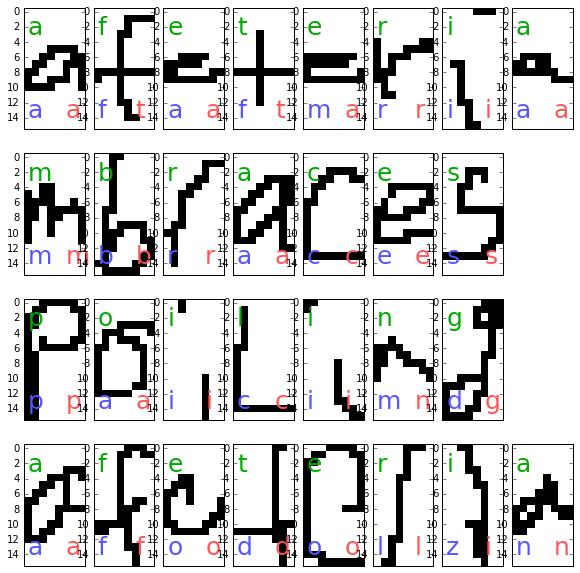

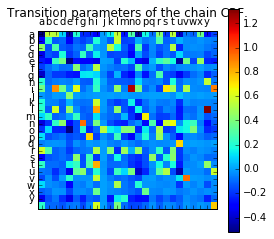

In [10]:
#plot some word sequenced
n_words = 4
rnd = np.random.RandomState(1)
selected = rnd.randint(len(y_test), size=n_words)
max_word_len = max([len(y_) for y_ in y_test[selected]])
fig, axes = plt.subplots(n_words, max_word_len, figsize=(10,10))
fig.subplots_adjust(wspace=0)
for ind, axes_row in zip(selected, axes):
    y_pred_svm = svm.predict(X_test[ind])
    y_pred_chain = ssvm.predict([X_test[ind]])[0]
    for i, (a, image, y_true, y_svm, y_chain) in enumerate(
    zip(axes_row, X_test[ind], y_test[ind], y_pred_svm, y_pred_chain)):
        a.matshow(image.reshape(16,8), cmap=plt.cm.Greys)
        a.text(0, 3, abc[y_true], color="#00AA00", size=25)
        a.text(0, 14, abc[y_svm], color="#5555FF", size=25)
        a.text(5, 14, abc[y_chain], color="#FF5555", size=25)
        a.set_xticks(())
    for ii in range(i+1, max_word_len):
        axes_row[ii].set_visible(False)
        
plt.matshow(ssvm.w[26*8*16:].reshape(26,26))
plt.colorbar()
plt.title("Transition parameters of the chain CRF.")
plt.xticks(np.arange(25), abc)
plt.yticks(np.arange(25), abc)
plt.show()